Notebook to evaluate multihead unet

In [1]:
import os
from pprint import pprint
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

sys.path.append("../")

from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_detection_dataloaders
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from monkey.model.hovernext.model import get_custom_hovernext
from monkey.model.loss_functions import get_loss_function
from monkey.model.utils import get_activation_function
from tqdm.autonotebook import tqdm
from monkey.model.utils import (
    get_multiclass_patch_F1_score_batch,
    get_patch_F1_score_batch,
)
from monkey.model.loss_functions import dice_coeff
from monkey.data.data_utils import imagenet_denormalise, dilate_mask

run_config = {
    "project_name": "Monkey_Multiclass_Detection",
    "model_name": "hovernext_det",
    "val_fold": 1,  # [1-5]
    "batch_size": 64,
    "optimizer": "AdamW",
    "learning_rate": 0.0004,
    "weight_decay": 0.01,
    "epochs": 50,
    "loss_function": {
        "head_1": "Weighted_BCE_Dice",
        "head_2": "Weighted_BCE_Dice",
        "head_3": "Weighted_BCE_Dice",
    },
    "loss_pos_weight": 10.0,
    "do_augmentation": True,
    "activation_function": {
        "head_1": "sigmoid",
        "head_2": "sigmoid",
        "head_3": "sigmoid",
    },
    "use_nuclick_masks": False,  # Whether to use NuClick segmentation masks,
    "include_background_channel": False,
}

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
)
if run_config["use_nuclick_masks"]:
    # Use NuClick masks
    IOconfig.set_mask_dir(
        "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
    )


# Create model
# model = get_multihead_efficientunet(
#     out_channels=run_config["out_channels"], pretrained=False
# )
model = get_custom_hovernext(pretrained=False)
checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cell_multiclass_det/hovernext_det/fold_{run_config['val_fold']}/epoch_50.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model"])
model.eval()
model.to("cuda")


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=run_config["batch_size"],
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
)


activation_dict = {
    "head_1": get_activation_function(
        run_config["activation_function"]["head_1"]
    ),
    "head_2": get_activation_function(
        run_config["activation_function"]["head_2"]
    ),
    "head_3": get_activation_function(
        run_config["activation_function"]["head_3"]
    ),
}

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


negative pixels: 728797440
lymph pixels: 11613440
mono pixels: 6044160
train patches: 11390
test patches: 2925


In [ ]:
def multihead_unet_post_process(
    logits_pred: torch.Tensor,
    activation_dict: dict[str, torch.nn.Module],
    thresholds: list = [0.3, 0.3, 0.3, 0.5],
) -> dict[str, np.ndarray]:
    """
    Args:
        Thresholds: [overall, lymph, mono, contour]
    """
    head_1_logits = logits_pred["head_1"]
    head_2_logits = logits_pred["head_2"]
    head_3_logits = logits_pred["head_3"]
    pred_probs_1 = activation_dict["head_1"](head_1_logits)
    pred_probs_2 = activation_dict["head_2"](head_2_logits)
    pred_probs_3 = activation_dict["head_3"](head_3_logits)

    contour_pred_binary = (
        (pred_probs_1[:, 1:2, :, :] > thresholds[3])
        .float()
        .numpy(force=True)
    )

    overall_pred_binary = (
        (pred_probs_1[:, 0:1, :, :] > thresholds[0])
        .float()
        .numpy(force=True)
    )
    lymph_pred_binary = (
        (pred_probs_2 > thresholds[1]).float().numpy(force=True)
    )
    mono_pred_binary = (
        (pred_probs_3 > thresholds[2]).float().numpy(force=True)
    )

    overall_pred_binary[contour_pred_binary == 1] = 0
    lymph_pred_binary[contour_pred_binary == 1] = 0
    mono_pred_binary[contour_pred_binary == 1] = 0

    processed_masks = {
        "inflamm_mask": overall_pred_binary[:, 0, :, :],
        "contour_mask": contour_pred_binary[:, 0, :, :],
        "lymph_mask": lymph_pred_binary[:, 0, :, :],
        "mono_mask": mono_pred_binary[:, 0, :, :],
        "inflamm_prob": pred_probs_1[:, 0, :, :].numpy(force=True),
        "contour_prob": pred_probs_1[:, 1, :, :].numpy(force=True),
        "lymph_prob": pred_probs_2[:, 0, :, :].numpy(force=True),
        "mono_prob": pred_probs_3[:, 0, :, :].numpy(force=True),
    }
    return processed_masks

In [2]:
def hovernext_det_post_process(
    inflamm_prob: torch.Tensor,
    lymph_prob: torch.Tensor,
    mono_prob: torch.Tensor,
    thresholds: list = [0.5, 0.5, 0.5],
):

    inflamm_prob = inflamm_prob.numpy(force=True)
    lymph_prob = lymph_prob.numpy(force=True)
    mono_prob = mono_prob.numpy(force=True)

    inflamm_prob = np.squeeze(inflamm_prob, axis=1)
    lymph_prob = np.squeeze(lymph_prob, axis=1)
    mono_prob = np.squeeze(mono_prob, axis=1)

    batches = inflamm_prob.shape[0]
    inflamm_output_mask = np.zeros(shape=(batches, 256, 256))
    lymph_output_mask = np.zeros(shape=(batches, 256, 256))
    mono_output_mask = np.zeros(shape=(batches, 256, 256))

    for i in range(0, batches):
        inflamm_coordinates = peak_local_max(
            inflamm_prob[i],
            min_distance=5,
            threshold_abs=thresholds[0],
            exclude_border=False,
        )
        inflamm_output_mask[i][
            inflamm_coordinates[:, 0], inflamm_coordinates[:, 1]
        ] = 1

        lymph_coordinates = peak_local_max(
            lymph_prob[i],
            min_distance=5,
            threshold_abs=thresholds[1],
            exclude_border=False,
        )
        lymph_output_mask[i][
            lymph_coordinates[:, 0], lymph_coordinates[:, 1]
        ] = 1

        mono_coordinates = peak_local_max(
            mono_prob[i],
            min_distance=5,
            threshold_abs=thresholds[2],
            exclude_border=False,
        )
        mono_output_mask[i][
            mono_coordinates[:, 0], mono_coordinates[:, 1]
        ] = 1

    return {
        "inflamm_mask": inflamm_output_mask,
        "lymph_mask": lymph_output_mask,
        "mono_mask": mono_output_mask,
    }

In [ ]:
running_overall_score = 0.0
running_lymph_score = 0.0
running_mono_score = 0.0
running_contour_score = 0.0

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):
    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    # contour_true_masks = (
    #     data["contour_mask"][:, 0, :, :].cpu().float()
    # )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        logits_pred = model(images)
        head_1_logits = logits_pred[:, 0:1, :, :]
        head_2_logits = logits_pred[:, 1:2, :, :]
        head_3_logits = logits_pred[:, 2:3, :, :]

        inflamm_prob = activation_dict["head_1"](head_1_logits)
        lymph_prob = activation_dict["head_2"](head_2_logits)
        mono_prob = activation_dict["head_3"](head_3_logits)

        processed_output = hovernext_det_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
            thresholds=[0.5, 0.5, 0.5],
        )

    # Compute detection F1 score
    overall_metrics = get_patch_F1_score_batch(
        processed_output["inflamm_mask"],
        inflamm_true_masks,
        inflamm_prob[:, 0, :, :],
    )
    lymph_metrics = get_patch_F1_score_batch(
        processed_output["lymph_mask"],
        lymph_true_masks,
        lymph_prob[:, 0, :, :],
    )
    mono_metrics = get_patch_F1_score_batch(
        processed_output["mono_mask"],
        mono_true_masks,
        mono_prob[:, 0, :, :],
    )
    # contour_dice = dice_coeff(
    #     torch.from_numpy(processed_output["contour_mask"]),
    #     contour_true_masks,
    #     reduce_batch_first=True,
    # )

    running_overall_score += (overall_metrics["F1"]) * images.size(0)
    running_lymph_score += (lymph_metrics["F1"]) * images.size(0)
    running_mono_score += (mono_metrics["F1"]) * images.size(0)
    # running_contour_score += contour_dice.item() * images.size(0)

results = {
    "overall_F1": running_overall_score / len(val_loader.sampler),
    "lymph_F1": running_lymph_score / len(val_loader.sampler),
    "mono_F1": running_mono_score / len(val_loader.sampler),
    # "contour_dice": running_contour_score / len(val_loader.sampler),
}

pprint(results)

{'lymph_F1': 0.48134467158539984,
 'mono_F1': 0.3571191506793695,
 'overall_F1': 0.5918179748513117}


Visualization

negative pixels: 728797440
lymph pixels: 11613440
mono pixels: 6044160
train patches: 11390
test patches: 2925


validation:   0%|          | 0/2925 [00:00<?, ?it/s]|2024-11-28|14:04:10.881| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


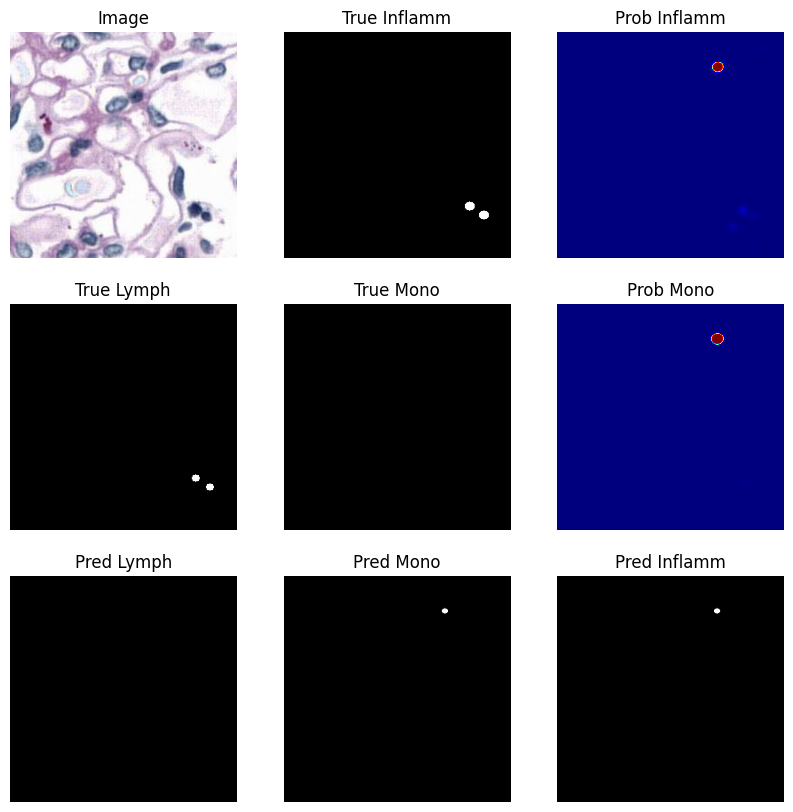

validation:   0%|          | 1/2925 [00:00<15:37,  3.12it/s]|2024-11-28|14:04:11.139| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


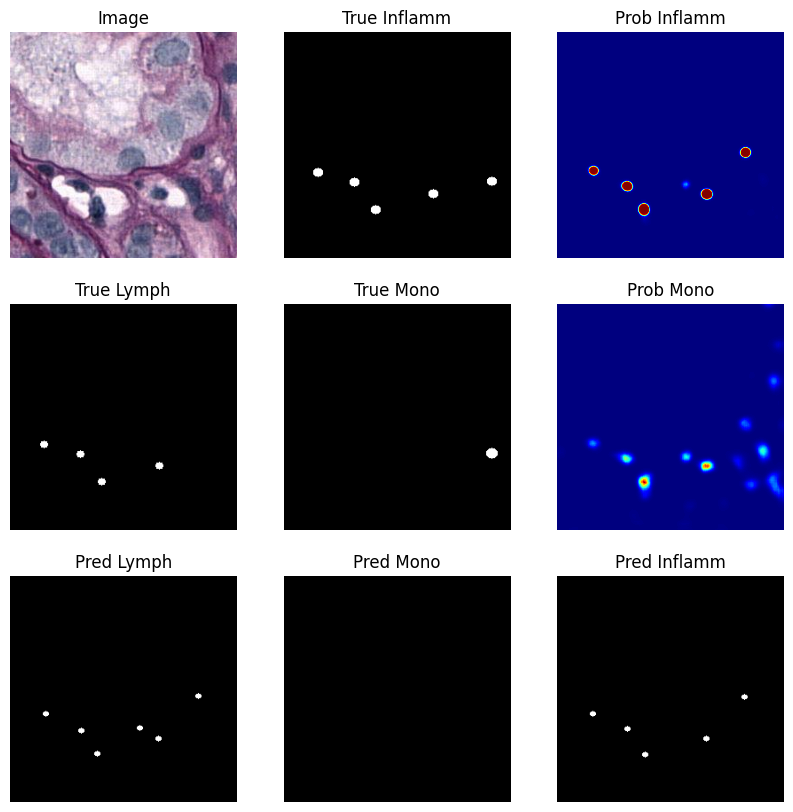

validation:   0%|          | 2/2925 [00:00<12:44,  3.82it/s]|2024-11-28|14:04:11.566| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


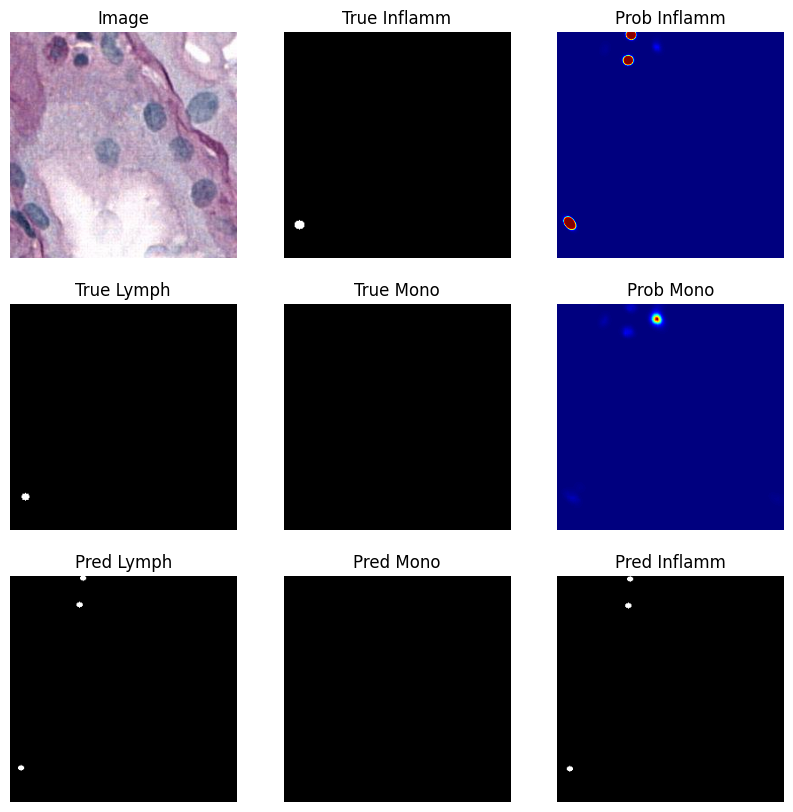

validation:   0%|          | 3/2925 [00:00<16:32,  2.94it/s]|2024-11-28|14:04:11.788| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


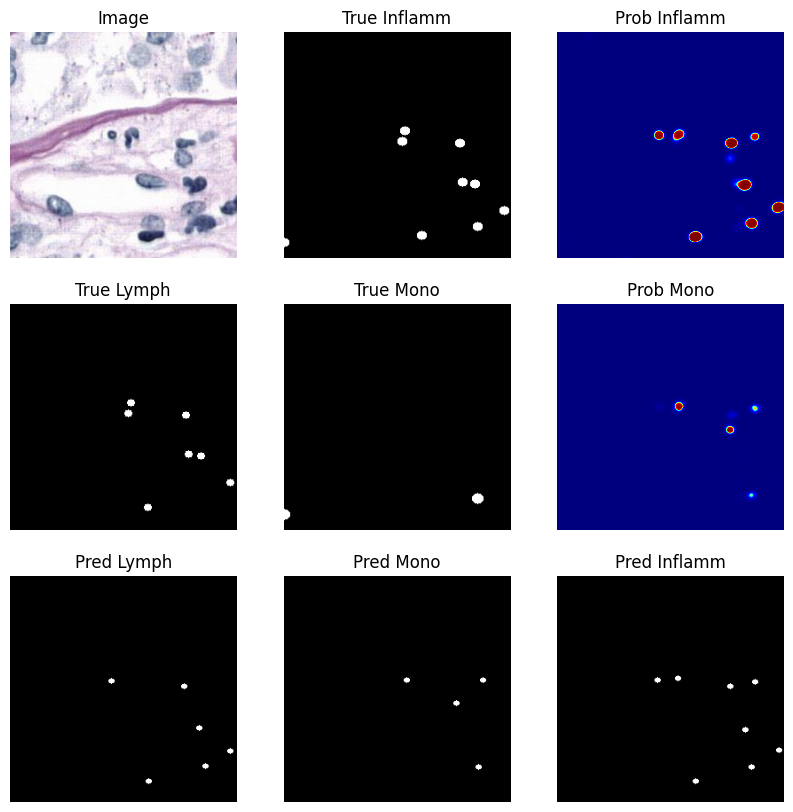

validation:   0%|          | 4/2925 [00:01<14:08,  3.44it/s]|2024-11-28|14:04:12.005| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


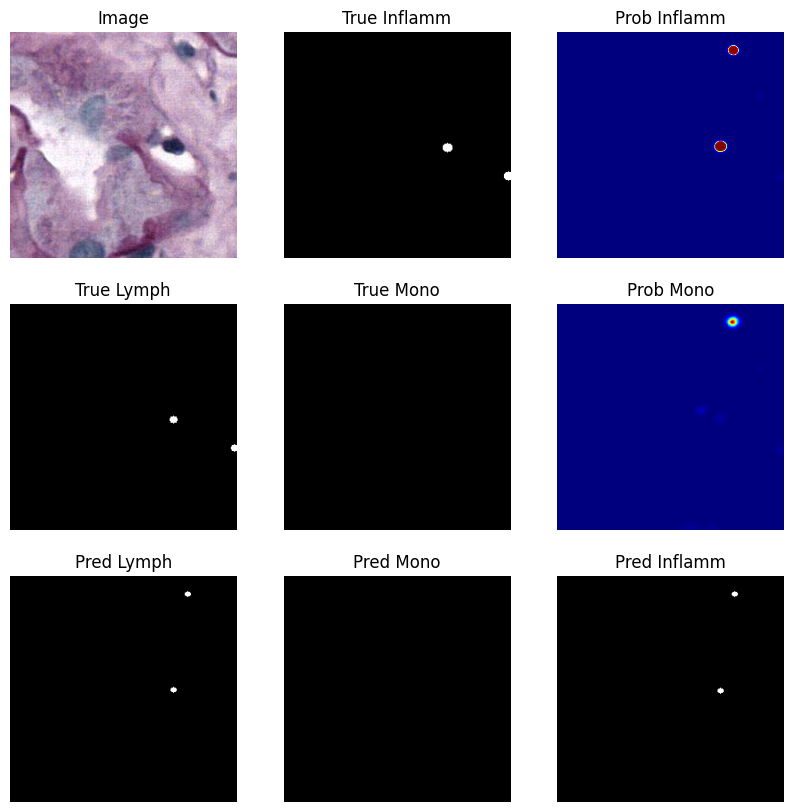

validation:   0%|          | 5/2925 [00:01<12:53,  3.78it/s]|2024-11-28|14:04:12.223| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


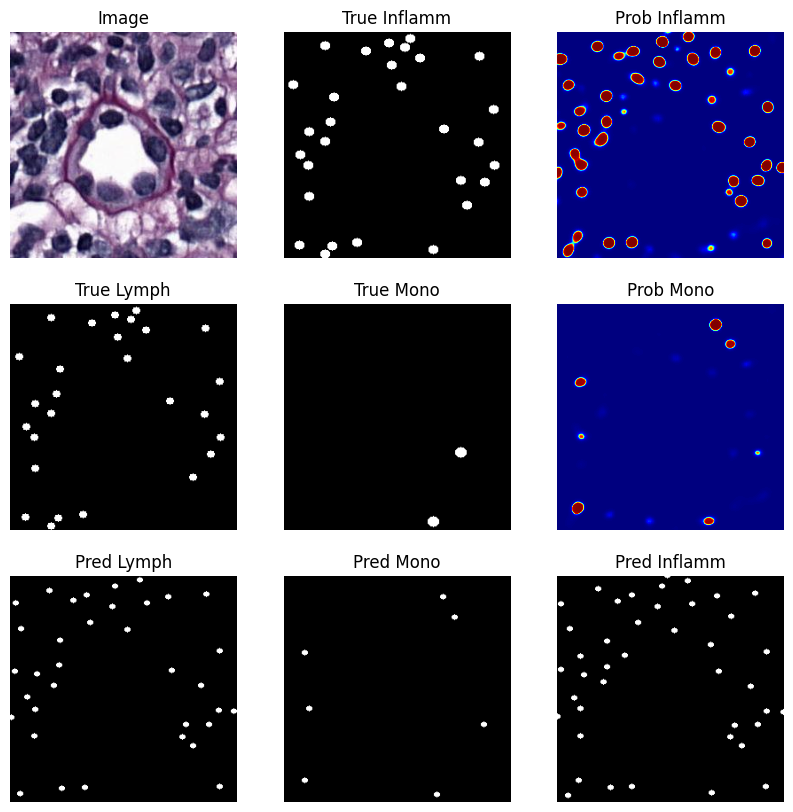

validation:   0%|          | 6/2925 [00:01<12:10,  4.00it/s]|2024-11-28|14:04:12.443| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


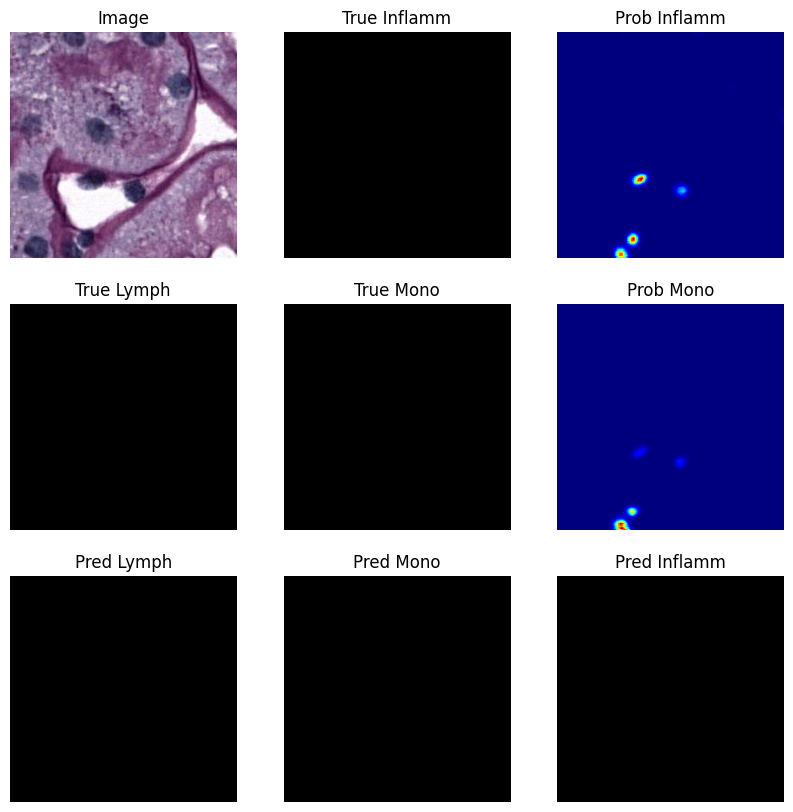

In [5]:
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="multitask",
    batch_size=1,
    do_augmentation=run_config["do_augmentation"],
    use_nuclick_masks=run_config["use_nuclick_masks"],
)

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))

    images = data["image"].cuda().float()
    inflamm_true_masks = data["binary_mask"][:, 0, :, :].numpy(
        force=True
    )
    # contour_true_masks = (
    #     data["contour_mask"][:, 0, :, :].cpu().float()
    # )
    lymph_true_masks = data["class_mask"][:, 0, :, :].numpy(
        force=True
    )
    mono_true_masks = data["class_mask"][:, 1, :, :].numpy(force=True)

    with torch.no_grad():
        logits_pred = model(images)
        head_1_logits = logits_pred[:, 0:1, :, :]
        head_2_logits = logits_pred[:, 1:2, :, :]
        head_3_logits = logits_pred[:, 2:3, :, :]

        inflamm_prob = activation_dict["head_1"](head_1_logits).cpu()
        lymph_prob = activation_dict["head_2"](head_2_logits).cpu()
        mono_prob = activation_dict["head_3"](head_3_logits).cpu()

        processed_output = hovernext_det_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
        )

    images = images.numpy(force=True)[0]
    images = np.moveaxis(images, 0, 2)
    images = imagenet_denormalise(images)

    axes[0][0].imshow(images)
    axes[0][0].set_title("Image")

    axes[0][1].imshow(inflamm_true_masks[0], cmap="gray")
    axes[0][1].set_title("True Inflamm")

    axes[0][2].imshow(inflamm_prob[0][0], cmap="jet")
    axes[0][2].set_title("Prob Inflamm")

    axes[1][0].imshow(lymph_true_masks[0], cmap="gray")
    axes[1][0].set_title("True Lymph")

    axes[1][1].imshow(mono_true_masks[0], cmap="gray")
    axes[1][1].set_title("True Mono")

    axes[1][2].imshow(mono_prob[0][0], cmap="jet")
    axes[1][2].set_title("Prob Mono")

    axes[2][0].imshow(
        dilate_mask(processed_output["lymph_mask"][0], 7), cmap="gray"
    )
    axes[2][0].set_title("Pred Lymph")

    axes[2][1].imshow(
        dilate_mask(processed_output["mono_mask"][0], 7), cmap="gray"
    )
    axes[2][1].set_title("Pred Mono")

    axes[2][2].imshow(
        dilate_mask(processed_output["inflamm_mask"][0], 7),
        cmap="gray",
    )
    axes[2][2].set_title("Pred Inflamm")

    for ax in axes.ravel():
        ax.axis("off")
    plt.show()

    if i > 5:
        break